In [1]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support, make_scorer,f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def mapping_x(cases):
    cases.sex = pd.Categorical(cases.sex).codes
    cases.chronic_disease_binary = pd.Categorical(cases.chronic_disease_binary).codes
    cases.country = pd.Categorical(cases.country).codes
    cases.loc[(cases.province.isnull()),'province'] = "no_prov"
    cases.province = pd.Categorical(cases.province).codes
    cases.date_confirmation = pd.Categorical(cases.date_confirmation).codes
    return cases

def mapping_y(cases):
    cases = cases.replace({'outcome_group': { 'deceased' : 0, 'hospitalized' : 1,'nonhospitalized': 2}})
    return cases

def readexcel():
    data_train = pd.read_excel('data/cases_2021_train_processed_2.xlsx')
    data_test = pd.read_excel('data/cases_2021_test_processed_unlabelled_2.xlsx')
    return data_train,data_test

def create_submission_file(y_preds, file_name): 
    with open(file_name, 'w') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL) 
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)]) 

In [3]:
def feature_selection(data_train_X, data_train_Y):
    bestfeatures = SelectKBest(score_func=chi2, k=11)
    fit = bestfeatures.fit(data_train_X,data_train_Y)
    dfscores = pd.DataFrame(fit.scores_)/1000
    dfcolumns = pd.DataFrame(data_train_X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    # get correlations of each features in dataset
    return featureScores.nlargest(14,'Score')  #print 10 best features

def corrmatx(data_train):
    corrmat = data_train.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(12,12))
    #plot heat map
    g=sns.heatmap(data_train.corr(),annot=True,cmap="RdYlGn")
    plt.show()

#Normalizing data
def normalize(data):
    X_norm = MinMaxScaler().fit_transform(data)
    X_norm = pd.DataFrame(X_norm, index=data.index, columns = data.columns)
    return X_norm

# https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
def balancing(data_X, data_y):
    sampling = RandomOverSampler(sampling_strategy='minority')
    X, y = sampling.fit_resample(data_X, data_y)
    return X, y

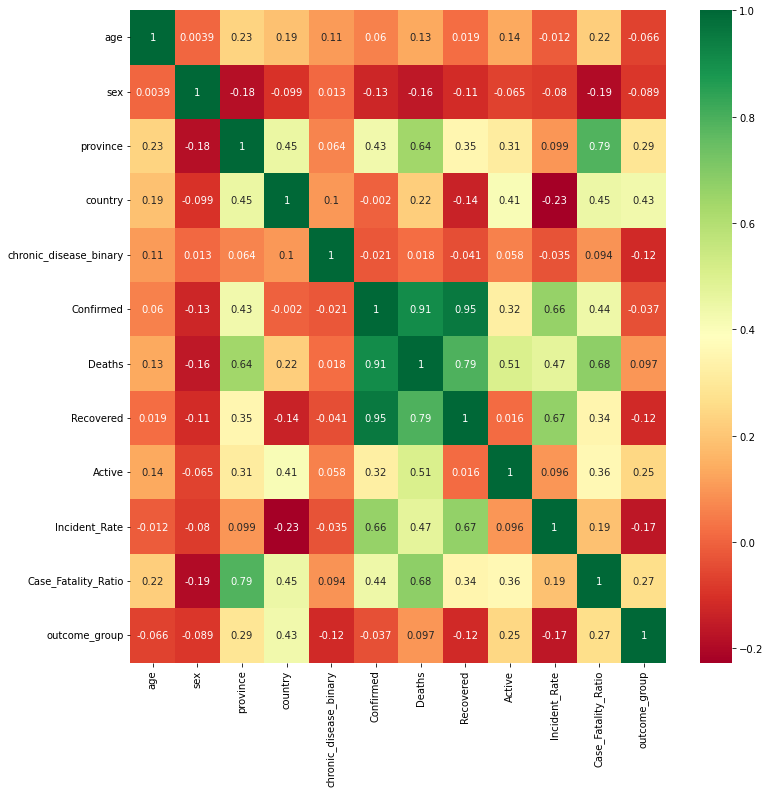

,Specs,Score
8,Active,795619.446469
7,Recovered,98230.637240
5,Confirmed,8643.536442
6,Deaths,1753.870457
9,Incident_Rate,357.923227
2,province,30.182135
0,age,18.265174
3,country,3.265574
4,chronic_disease_binary,0.854955
10,Case_Fatality_Ratio,0.634786


In [4]:
#Data
data_train,data_test = readexcel()
data_train = mapping_x(data_train)
data_train = mapping_y(data_train)
data_train = data_train.drop(['latitude', 'longitude', 'date_confirmation'], axis = 1)
data_test = mapping_x(data_test)
data_test = data_test.drop(['latitude', 'longitude', 'date_confirmation'], axis = 1)
data_train_X = data_train.drop(['outcome_group'], axis = 1)
data_train_Y = data_train[['outcome_group']]
corrmatx(data_train)
score = feature_selection(data_train_X,data_train_Y)
score

In [5]:
features = ['age','province', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate']

In [6]:
newX = data_train_X[features]
newTest = data_test[features]

train_X = normalize(newX)
test_X = normalize(newTest)
Xtrain, Xval, Ytrain, Yval = train_test_split(train_X, data_train_Y, test_size=0.20) 
trainX,trainY = balancing(Xtrain, Ytrain)

Knn

In [7]:
def f1scoremetricscore(og, pred):
    return precision_recall_fscore_support(og,pred, labels=[0])[2]

param = {
    'n_neighbors':np.arange(3,50,3),
    'weights':['distance'],
    'p': [1,2],
    'metric': ['euclidean','minkowski']
}
scoring = {
    'macrof1': make_scorer(f1_score, average = 'macro'),
    'specf_f1score': make_scorer(f1scoremetricscore),
    'accuracy': make_scorer(accuracy_score)
}

In [8]:
cvknn = KNeighborsClassifier()
grcv = GridSearchCV(cvknn,param,verbose=True,cv = 5,scoring = scoring,refit = 'macrof1',n_jobs=-1)
grcv.fit(trainX,trainY.values.ravel())
print(grcv.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
KNeighborsClassifier(n_neighbors=48, p=1, weights='distance')


In [9]:
grcv.best_params_

{'metric': 'minkowski', 'n_neighbors': 48, 'p': 1, 'weights': 'distance'}

In [10]:
#Best params
ypred_val_knn = grcv.predict(Xval)
ypred_tr_knn = grcv.predict(Xtrain)
print(accuracy_score(Yval,ypred_val_knn))
print("Validation set")
print(classification_report(Yval,ypred_val_knn))
print("\nTraining set")
print(classification_report(Ytrain,ypred_tr_knn))

0.9105431309904153
Validation set
              precision    recall  f1-score   support

           0       0.37      0.56      0.45       202
           1       0.98      0.97      0.97      2679
           2       0.86      0.77      0.82       562

    accuracy                           0.91      3443
   macro avg       0.74      0.77      0.75      3443
weighted avg       0.93      0.91      0.92      3443


Training set
              precision    recall  f1-score   support

           0       0.48      0.63      0.54       795
           1       0.99      0.98      0.98     10562
           2       0.91      0.83      0.87      2412

    accuracy                           0.93     13769
   macro avg       0.79      0.81      0.80     13769
weighted avg       0.94      0.93      0.94     13769



In [11]:
model = RandomForestClassifier(random_state=42,class_weight='balanced')
grid = { 
  'criterion': ['gini', 'entropy'],
    'n_estimators': np.arange(10, 210, 10),
    'max_features': ['log2'],
    'min_samples_leaf': [2, 3],
    'max_depth': [60, 70, 80, 90, 100]
}
rf_cv = RandomizedSearchCV(model, grid, cv = 5,n_jobs=-1,scoring=scoring,n_iter=70,refit='macrof1',verbose=1)
rf_cv.fit(Xtrain,Ytrain.values.ravel())
print(rf_cv.best_estimator_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=60, max_features='log2', min_samples_leaf=3,
                       n_estimators=190, random_state=42)


In [12]:
print(rf_cv.best_params_)

{'n_estimators': 190, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 60, 'criterion': 'entropy'}


In [13]:
#Best params
ypred_val_rf = rf_cv.predict(Xval)
ypred_tr_rf = rf_cv.predict(Xtrain)
print(accuracy_score(Yval,ypred_val_rf))
print('Validation set')
print(classification_report(Yval,ypred_val_rf))
print("\nTraining set")
print(classification_report(Ytrain,ypred_tr_rf))

0.9102526866105141
Validation set
              precision    recall  f1-score   support

           0       0.38      0.63      0.47       202
           1       0.98      0.97      0.98      2679
           2       0.88      0.74      0.80       562

    accuracy                           0.91      3443
   macro avg       0.75      0.78      0.75      3443
weighted avg       0.93      0.91      0.92      3443


Training set
              precision    recall  f1-score   support

           0       0.43      0.72      0.54       795
           1       0.98      0.97      0.98     10562
           2       0.93      0.76      0.83      2412

    accuracy                           0.92     13769
   macro avg       0.78      0.82      0.78     13769
weighted avg       0.94      0.92      0.93     13769



In [14]:
ypredtestrf = rf_cv.predict(test_X)
create_submission_file(ypredtestrf,"predictions.csv")

In [15]:
deceasedf1_knn = grcv.cv_results_['mean_test_specf_f1score']
macrof1_knn = grcv.cv_results_['mean_test_macrof1']
accuracy_knn = grcv.cv_results_['mean_test_accuracy']
combinations_knn = grcv.cv_results_['params']

deceasedf1 = rf_cv.cv_results_['mean_test_specf_f1score']
macrof1 = rf_cv.cv_results_['mean_test_macrof1']
accuracy = rf_cv.cv_results_['mean_test_accuracy']
combinations = rf_cv.cv_results_['params']

In [16]:
f1scoresknn = pd.DataFrame(np.column_stack([combinations_knn,macrof1_knn, deceasedf1_knn,accuracy_knn]), 
             columns=['hyp_combinations','f1score_macro' ,'f1score_deceased','overallaccracy'])
f1scoresrf = pd.DataFrame(np.column_stack([combinations,macrof1, deceasedf1,accuracy]), 
             columns=['hyp_combinations','f1score_macro' ,'f1score_deceased','overallaccracy'])

In [17]:
f1scoresknn.to_csv('results/knn_tuning.txt', index=None, sep='\t', mode='w')
f1scoresrf.to_csv('results/random_forest_tuning.txt', index=None, sep='\t', mode='w')

In [18]:
print(f1scoresknn.iloc[grcv.best_index_])
print(f1scoresrf.iloc[rf_cv.best_index_])

hyp_combinations    {'metric': 'minkowski', 'n_neighbors': 48, 'p'...
f1score_macro                                                0.757967
f1score_deceased                                             0.776641
overallaccracy                                               0.818066
Name: 62, dtype: object
hyp_combinations    {'n_estimators': 190, 'min_samples_leaf': 3, '...
f1score_macro                                                0.757504
f1score_deceased                                             0.472611
overallaccracy                                               0.911686
Name: 2, dtype: object


In [19]:
#FOR KNN
{'metric': 'minkowski', 
 'n_neighbors': 24, 'p': 1, 
 'weights': 'distance'}

{'metric': 'minkowski', 'n_neighbors': 24, 'p': 1, 'weights': 'distance'}

In [20]:
#FOR RANDOM FOREST 
{'n_estimators': 180, 'min_samples_leaf': 3,
  'max_features': 'log2', 'max_depth': 100,
  'criterion': 'entropy'}

{'n_estimators': 180,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 100,
 'criterion': 'entropy'}

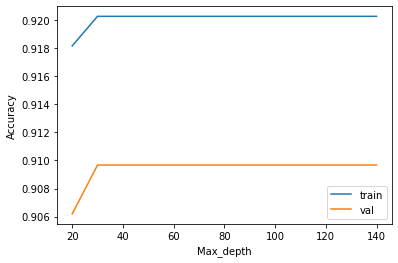

In [26]:
#Plot to check overfit
neigh = np.arange(3,50,3)
dept = np.arange(20,150,10)
valacc= []
tracc = []
for n in neigh:
    knnplot = KNeighborsClassifier(n_neighbors=n, p=1, weights='distance')
    knnplot.fit(Xtrain,Ytrain.values.ravel())
    ypred =  knnplot.predict(Xtrain)
    tracc.append(accuracy_score(Ytrain,ypred))
    ypred =  knnplot.predict(Xval)
    valacc.append(accuracy_score(Yval,ypred))
plt.plot(neigh,tracc)
plt.plot(neigh,valacc)
plt.legend(['train','val'])
plt.xlabel("N_Neighbors")
plt.ylabel("Accuracy")
plt.savefig("Overfit_KNN.png")
valacc= []
tracc = []
for d in dept:
    rfplot = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=d, max_features='log2', min_samples_leaf=3,
                       n_estimators=80, random_state=42)
    rfplot.fit(Xtrain,Ytrain.values.ravel())
    ypred =  rfplot.predict(Xtrain)
    tracc.append(accuracy_score(Ytrain,ypred))
    ypred =  rfplot.predict(Xval)
    valacc.append(accuracy_score(Yval,ypred))
plt.clf()
plt.plot(dept,tracc)
plt.plot(dept,valacc)
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")
plt.legend(['train','val'])
plt.savefig("Overfit_RandomForest.png")